In [1]:
import os
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sparsecoding.data.transforms.patch import sample_random_patches
from sparsecoding import inference

from sparsecoding import models
from sparsecoding.visualization import plot_dictionary

### Define constants and load data

In [2]:
# your path here
img_dir = os.path.join(os.environ['DATA_PATH'],'data','IMAGES.mat')

images = loadmat(img_dir)['IMAGES']
images = torch.tensor(images).permute([2,0,1]).unsqueeze(1)
images = images.type(torch.float32)
print(images.shape)

torch.Size([10, 1, 512, 512])


In [3]:
n_images = images.shape[-1]
# n_divisions = 32

# image_data, n_images, n_divisions, patch_size_x, patch_size_y = patch_images(images, n_divisions=n_divisions)
# data = preprocess_images(image_data, patch_size_x, patch_size_y)

n_patches = 100
patch_size = 16
patches = sample_random_patches(image=images, patch_size=patch_size, num_patches=n_patches)
data = patches.reshape([n_patches, -1])

n_samples, n_features = data.shape

### Visualize patches

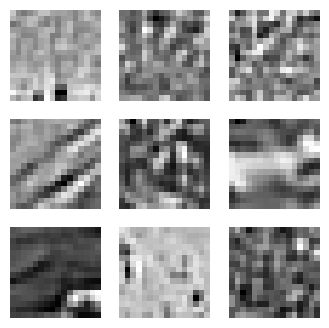

In [4]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size, patch_size]), cmap="gray")
plt.show()

### Sparse Coding via Dictionary Learning

In [5]:
### DEFINE MODEL
lca = inference.LCA(coeff_lr=1e-3,threshold=0.1,n_iter=300)
sc = models.SparseCoding(inference_method=lca,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

In [6]:
%matplotlib notebook

n_epoch = 100
montage_update_rate = 10

# Plot Updates
nrow = 16
fig,ax = plot_dictionary(sc.dictionary,nrow=nrow)

losses = np.array([])

for i in range(n_epoch//montage_update_rate):
    # learn dictionary
    loss = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    losses = np.concatenate([losses,loss])
    # update montage
    fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(i*montage_update_rate,n_epoch),nrow=nrow)

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch),nrow=nrow)

<IPython.core.display.Javascript object>

In [10]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(losses)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('loss')
plt.show()

<IPython.core.display.Javascript object>